In [1]:
# Fixing automatic autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

from monai.data import  DataLoader
from monai.losses import DiceLoss
from torch.optim import Adam

from utils import (
    read_data, 
    get_metadata,
    crop_and_upscale_tissue,
    get_image_tensor_from_path
)

from dataset import OcelotCellDataset
from deeplabv3.network.modeling import _segm_resnet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


In [3]:
model = _segm_resnet(
    name="deeplabv3plus",
    backbone_name="resnet50",
    num_classes=3,
    output_stride=8,
    pretrained_backbone=True,
)
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [4]:
folder_path = "ocelot_data/"
metadata = get_metadata(folder_path)
data = read_data(folder_path)

Skipped file number 217 as the .csv was empty.
Skipped file number 042 as the .csv was empty.
Skipped file number 053 as the .csv was empty.
Skipped file number 008 as the .csv was empty.
Skipped file number 392 as the .csv was empty.
Skipped file number 570 as the .csv was empty.
Skipped file number 558 as the .csv was empty.


In [5]:
segmented_cell_folder = "ocelot_data/annotations/train/segmented_cell/"
cell_annotations = []
for f_name in sorted(list(data.keys())):
    image_path = os.path.join(segmented_cell_folder, f"{f_name}.png")
    cell_annotation = get_image_tensor_from_path(image_path)
    cell_annotations.append(cell_annotation)

cell_annotations_tensor = torch.stack(cell_annotations)

In [6]:
cell_channels_with_tissue_annotations = []
image_size = 1024

for data_id in sorted(list(data.keys())):
    data_object = data[data_id]
    offset_tensor = torch.tensor([data_object["x_offset"], data_object["y_offset"]]) * image_size
    scaling_value = data_object["cell_mpp"] / data_object["tissue_mpp"]
    tissue_tensor = data_object["tissue_annotated"]
    cell_tensor = data_object["cell_image"]

    cropped_scaled = crop_and_upscale_tissue(tissue_tensor, offset_tensor, scaling_value)
    cell_tensor_tissue_annotation = torch.cat([cell_tensor, cropped_scaled], 0)
    
    cell_channels_with_tissue_annotations.append(cell_tensor_tissue_annotation)



tissue_crops_scaled_tensor = torch.stack(cell_channels_with_tissue_annotations)

/Users/jarl/school/fall23/specialization_project/histopathology_segmentation/utils.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(resized_tensor, dtype=torch.uint8)


In [14]:
dataset = OcelotCellDataset(
    img=tissue_crops_scaled_tensor,
    seg=cell_annotations_tensor,
)

NameError: name 'tissue_crops_scaled_tensor' is not defined

In [8]:
data_loader = DataLoader(dataset=dataset, batch_size=2)
loss_function = DiceLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [10]:
import time
num_epochs = 2
decode_fn = data_loader.dataset.decode_target

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start = time.time()

    for (inputs, labels) in data_loader:
        inputs, labels = inputs.to(device), labels.to(device).squeeze()
        optimizer.zero_grad()

        outputs = model(inputs.to(torch.float32))
        outputs = decode_fn(outputs).to(torch.float32)
        outputs.requires_grad = True

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    end = time.time()
    epoch_loss /= len(data_loader)
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss}, epoch_time: {end-start:.2f} seconds")

file_path = 'model_checkpoint.pth'

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

# Save the checkpoint to the file
torch.save(checkpoint, file_path)

Did one iteration!
Did one iteration!
Did one iteration!


KeyboardInterrupt: 

torch.Size([2, 3, 1024, 1024])


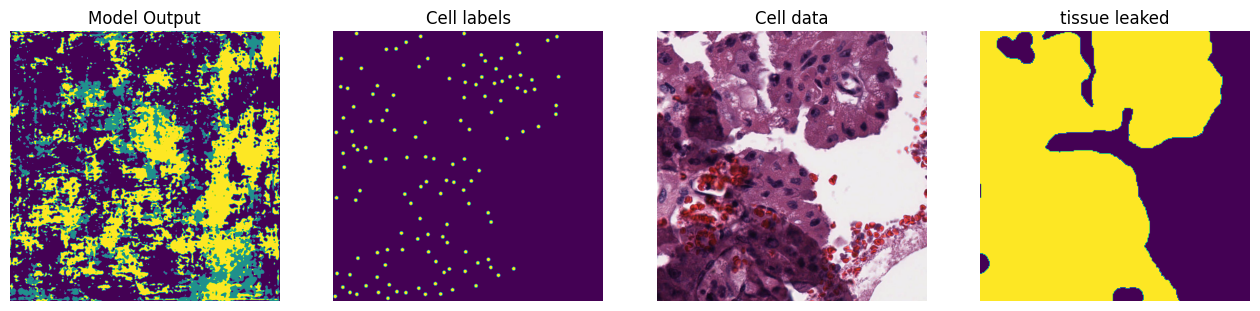

In [11]:
import matplotlib.pyplot as plt

inputs, labels = data_loader.__iter__()._next_data()
outputs = model(inputs.to(torch.float32))
print(outputs.size())

decode_fn = data_loader.dataset.decode_target

outputs1 = decode_fn(outputs)[0]
plt.figure(figsize=(16, 8))  # Adjust the width and height as needed

plt.subplot(1, 4, 1)
plt.title("Model Output")
plt.axis("off")
plt.imshow(outputs1)

plt.subplot(1, 4, 4)
plt.title("tissue leaked")
plt.imshow(inputs[0, 3])
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Cell data")
plt.axis("off")
plt.imshow(inputs[0, :3].permute((1, 2, 0)))

plt.subplot(1, 4, 2)
plt.title("Cell labels")
plt.imshow(labels[0].squeeze())
plt.axis("off")

plt.show()